# 주식매매 전략의 구현과 검증

## (1) 단순 매매 전략

## (2) 머신러닝(SVR)모델을 적용한 전략

## (3) 동적시간워핑 모델링을 적용한 전략

### 참고서적:  생활 속 문제를 통해 배워보는 머신 러닝 (2017.11.30), ch7

### 작성자: 김도완


In [1]:
# pandas_datareader 사용해 주가 데이터 받기
# 야후 파이낸스 사용 안정성 떨어짐. 불안하다.

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import pandas_datareader as pdr
import fix_yahoo_finance as yf # 야후 파이낸스이용시 패치필요

yf.pdr_override()

#한꺼번에 주석처리 ctrl+/
print(pd.__version__)
print(pdr.__version__)

start_date= pd.to_datetime('2010-01-01')
end_date= pd.to_datetime('2018-10-12')
HY= pdr.data.get_data_yahoo('005930.KS', start_date, end_date) # 현대차
#HY['Adj Close'].tail(5)
HY.tail(5)

0.22.0
0.5.0
[*********************100%***********************]  1 of 1 downloaded


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2018-10-05,44800.0,45500.0,44550.0,44700.0,44700.0,10544165
2018-10-08,44200.0,45200.0,44200.0,44950.0,44950.0,6759464
2018-10-10,45250.0,45500.0,44500.0,45300.0,45300.0,10341349
2018-10-11,44000.0,44650.0,43100.0,43100.0,43100.0,19324537
2018-10-12,43200.0,44650.0,43200.0,44000.0,44000.0,12640906


In [2]:
HY.shape

(2165, 6)

In [3]:
# 단순 매매전략 확인
HY['Daily Change']= pd.Series(HY['Close'] - HY['Open']) #당일종가 - 당일시가
HY['Overnight Change']= pd.Series(HY['Open']- HY['Close'].shift(1)) #당일시가 - 전일종가, 종가배팅
HY.head()

,Open,High,Low,Close,Adj Close,Volume,Daily Change,Overnight Change
Date,,,,,,,,
2010-01-04,16060.0,16180.0,16000.0,16180.0,5.908792,11950800,120.0,NaN
2010-01-05,16520.0,16580.0,16300.0,16440.0,6.003742,27925850,-80.0,340.0
2010-01-06,16580.0,16820.0,16520.0,16820.0,6.142515,22948850,240.0,140.0
2010-01-07,16820.0,16820.0,16260.0,16260.0,5.938008,22107950,-560.0,0.0
2010-01-08,16400.0,16420.0,16120.0,16420.0,5.996438,14777550,20.0,140.0


In [4]:
print('당일매매 수익 표준편차:', np.std(HY['Daily Change']))
print('당일매매 수익 평균:', HY['Daily Change'].mean())
print('당일매매 수익 총합:', HY['Daily Change'].sum())

print('오버나잇매매 표준편차:', np.std(HY['Overnight Change']))
print('오버나잇매매 수익 평균:', HY['Overnight Change'].mean())
print('오버나잇매매 수익 총합:', HY['Overnight Change'].sum())

당일매매 수익 표준편차: 420.7742683186709
당일매매 수익 평균: -4.212471131639723
당일매매 수익 총합: -9120.0
오버나잇매매 표준편차: 314.8168802969416
오버나잇매매 수익 평균: 17.12569316081331
오버나잇매매 수익 총합: 37060.0


In [12]:
print(HY[HY['Daily Change']>0]['Daily Change'].sum()) # 수익 합
print(HY[HY['Daily Change']<0]['Daily Change'].sum()) # 손실 합

324930.0
-334050.0


In [13]:
# 단순매매전략 검증
# S1: 당일시가 매수 -> 당일종가 매도
# S2: 전일종가 매수 -> 당일시가 매도 (종가배팅)
# S3: 전일종가 매수 -> 당일종가 매도 
S1 = (HY['Close'] - HY['Open']) / HY['Open'] * 100 # 수익률(%)로 표현
S2 = (HY['Open'] - HY['Close'].shift(1)) / HY['Close'].shift(1) * 100
S3 = (HY['Close'] - HY['Close'].shift(1)) / HY['Close'].shift(1) * 100



In [37]:
print(S3.head())
print(S3.cumsum().head())
print(S3.cumsum().tail())
S3.sum()

Date
2010-01-04         NaN
2010-01-05    1.606922
2010-01-06    2.311436
2010-01-07   -3.329370
2010-01-08    0.984010
Name: Close, dtype: float64
Date
2010-01-04         NaN
2010-01-05    1.606922
2010-01-06    3.918358
2010-01-07    0.588988
2010-01-08    1.572998
Name: Close, dtype: float64
Date
2018-10-05    133.619657
2018-10-08    134.178942
2018-10-10    134.957584
2018-10-11    130.101072
2018-10-12    132.189239
Name: Close, dtype: float64


132.1892393500694

In [14]:
# 전략검증함수
def get_stats(s, n=252):
    s= s.dropna()
    wins= len(s[s>0]) # 승리 횟수
    losses= len(s[s<0]) # 패배 횟수
    evens= len(s[s==0]) # 무승부 횟수
    mean_w= round(s[s>0].mean(), 3)
    mean_l= round(s[s<0].mean(), 3)
    win_r= round(wins/losses, 3) # 승리 패배 비율
    mean_trd= round(s.mean(), 3) 
    sd= round(np.std(s), 3) # 표준편차
    max_l= round(s.min(), 3)
    max_w= round(s.max(), 3)
    sharpe_r= round((s.mean()/np.std(s))*np.sqrt(n), 4) # 샤프지수, n은 1년 평일수
    cnt= len(s)
    print('Trade:', cnt, \
          '\nWins:', wins, \
          '\nLossed:', losses, \
          '\nBreakeven:', evens, \
          '\nWin/Loss Ratio:', win_r, \
          '\nMean Win:', mean_w, \
          '\nMean Loss:', mean_l, \
          '\nProfit/Loss Ratio:', abs(round(mean_w/mean_l, 3)), \
          '\nMean', mean_trd, \
          '\nStd Dev:', sd, \
          '\nMax Loss:', max_l, \
          '\nMax Win:', max_w, \
          '\nSharpe Ratio:', sharpe_r)
    
# 샤프지수는 높을수록 좋다. 변동성은 낮을수록 좋다, 최대이익은 늘리고 최대손실은 줄인다.
# 샤프지수 의미 ??
# 투자 자산 또는 매매 전략에서, 일반적으로 위험이라 불리는 편차 한 단위당 초과수익을 의미한다. 
# 샤프지수 = (평균수익률 - 국고채평균수익률, 즉 무위험수익률) / 수익률표준편차
# 예를 들어 1년동안 코스피가 20% 오르고 내 포트폴리오가 30% 올랐는데, 
# 내 포트폴리오의 월간 수익률에서 코스피의 월간 수익률을 뺀 값의 표준편차가 5%라면,
# 사후적 샤프 비율은 (0.3-0.2)/(0.05*12^(1/2)) = 약 0.57이 된다. (월간 표준편차를 연간 표준편차로 바꾸기 위해 12의 제곱근을 곱함)


In [15]:
get_stats(S1) # S1: 당일시가 매수 -> 당일종가 매도

Trade: 2165 
Wins: 1033 
Lossed: 1047 
Breakeven: 85 
Win/Loss Ratio: 0.987 
Mean Win: 1.119 
Mean Loss: -1.12 
Profit/Loss Ratio: 0.999 
Mean -0.008 
Std Dev: 1.403 
Max Loss: -5.263 
Max Win: 5.457 
Sharpe Ratio: -0.089


In [16]:
get_stats(S2) # S2: 전일종가 매수 -> 당일시가 매도

Trade: 2164 
Wins: 1027 
Lossed: 849 
Breakeven: 288 
Win/Loss Ratio: 1.21 
Mean Win: 0.849 
Mean Loss: -0.849 
Profit/Loss Ratio: 1.0 
Mean 0.07 
Std Dev: 1.046 
Max Loss: -6.745 
Max Win: 5.995 
Sharpe Ratio: 1.0589


In [17]:
get_stats(S3) # S3: 전일종가 매수 -> 당일종가 매도

Trade: 2164 
Wins: 1076 
Lossed: 1012 
Breakeven: 76 
Win/Loss Ratio: 1.063 
Mean Win: 1.374 
Mean Loss: -1.33 
Profit/Loss Ratio: 1.033 
Mean 0.061 
Std Dev: 1.724 
Max Loss: -8.036 
Max Win: 8.688 
Sharpe Ratio: 0.5625


In [15]:
# 누적수익곡선
def get_cumsum(s):
    # 누적 수익률, 전략검증값 확인
    cumsum_series= s.cumsum()
    print('수익률 총합:', s.sum())

    fig= plt.figure(figsize=(8,4))
    ax= fig.add_subplot(1,1,1)
    ax.plot(cumsum_series.index, cumsum_series.values)
    ax.set_ylabel('Cum Profit')
    ax.grid()


수익률 총합: -17.02227390169169
수익률 총합: 151.00769967584563
수익률 총합: 132.1892393500694


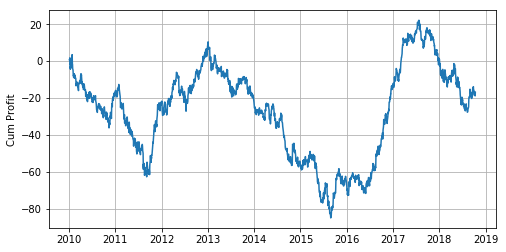

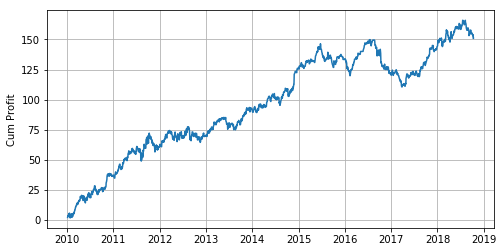

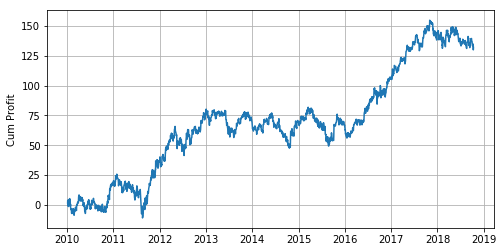

In [35]:
get_cumsum(S1)
get_cumsum(S2)
get_cumsum(S3) 

In [38]:
# 거래수수료 및 세금을 고려하지 않았다. (키움증권 기준 0.33%)
# 수익총합에서 2164 * 0.33 = 714.12(%) 마이너스해야한다.

In [59]:
# 이평선 매매 전략

# 5이평 > 20이평일때 매수, 5이평 < 20이평일때 매도







In [1]:
# 주가의 이전 마감주가를 사용해 다음날 마감주가를 예측하는 모델, SVR사용

# pandas_datareader 사용해 주가 데이터 받기
# 야후 파이낸스 사용 안정성 떨어짐. 불안하다.

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import pandas_datareader as pdr
import fix_yahoo_finance as yf # 야후 파이낸스이용시 패치필요

yf.pdr_override()

#한꺼번에 주석처리 ctrl+/
print(pd.__version__)
print(pdr.__version__)

start_date= pd.to_datetime('2010-01-01')
end_date= pd.to_datetime('2018-10-12')
HY= pdr.data.get_data_yahoo('005930.KS', start_date, end_date)
#HY['Adj Close'].tail(5)
HY.tail(5)

0.22.0
0.5.0
[*********************100%***********************]  1 of 1 downloaded


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2018-10-05,44800.0,45500.0,44550.0,44700.0,44700.0,10544165
2018-10-08,44200.0,45200.0,44200.0,44950.0,44950.0,6759464
2018-10-10,45250.0,45500.0,44500.0,45300.0,45300.0,10341349
2018-10-11,44000.0,44650.0,43100.0,43100.0,43100.0,19324537
2018-10-12,43200.0,44650.0,43200.0,44000.0,44000.0,12640906


In [2]:
for i in range(1,21):
    HY.loc[:,'Close Minus'+str(i)]= HY['Close'].shift(i)
    HY20= HY[[x for x in HY.columns if 'Close Minus' in x or x=='Close']]

print(len(HY20))
HY20.head(5)
    

2165


,Close,Close Minus1,Close Minus2,Close Minus3,Close Minus4,Close Minus5,Close Minus6,Close Minus7,Close Minus8,Close Minus9,...,Close Minus11,Close Minus12,Close Minus13,Close Minus14,Close Minus15,Close Minus16,Close Minus17,Close Minus18,Close Minus19,Close Minus20
Date,,,,,,,,,,,,,,,,,,,,,
2010-01-04,16180.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-05,16440.0,16180.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-06,16820.0,16440.0,16180.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-07,16260.0,16820.0,16440.0,16180.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-08,16420.0,16260.0,16820.0,16440.0,16180.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
HY20_d = HY20.dropna()

In [4]:
HY20_d[:5]

,Close,Close Minus1,Close Minus2,Close Minus3,Close Minus4,Close Minus5,Close Minus6,Close Minus7,Close Minus8,Close Minus9,...,Close Minus11,Close Minus12,Close Minus13,Close Minus14,Close Minus15,Close Minus16,Close Minus17,Close Minus18,Close Minus19,Close Minus20
Date,,,,,,,,,,,,,,,,,,,,,
2010-02-01,15540.0,15680.0,16160.0,16000.0,16300.0,16840.0,16500.0,17000.0,16680.0,16460.0,...,16840.0,16540.0,15940.0,16180.0,15940.0,16420.0,16260.0,16820.0,16440.0,16180.0
2010-02-02,15440.0,15540.0,15680.0,16160.0,16000.0,16300.0,16840.0,16500.0,17000.0,16680.0,...,16860.0,16840.0,16540.0,15940.0,16180.0,15940.0,16420.0,16260.0,16820.0,16440.0
2010-02-03,15540.0,15440.0,15540.0,15680.0,16160.0,16000.0,16300.0,16840.0,16500.0,17000.0,...,16460.0,16860.0,16840.0,16540.0,15940.0,16180.0,15940.0,16420.0,16260.0,16820.0
2010-02-04,15520.0,15540.0,15440.0,15540.0,15680.0,16160.0,16000.0,16300.0,16840.0,16500.0,...,16680.0,16460.0,16860.0,16840.0,16540.0,15940.0,16180.0,15940.0,16420.0,16260.0
2010-02-05,15000.0,15520.0,15540.0,15440.0,15540.0,15680.0,16160.0,16000.0,16300.0,16840.0,...,17000.0,16680.0,16460.0,16860.0,16840.0,16540.0,15940.0,16180.0,15940.0,16420.0


In [5]:
# 칼럼을 시간기준으로 왼쪽에서 오른쪽으로 정렬한다.
HY20_d = HY20_d.iloc[:,::-1]
print(len(HY20_d))
HY20_d.head(5)

2145


,Close Minus20,Close Minus19,Close Minus18,Close Minus17,Close Minus16,Close Minus15,Close Minus14,Close Minus13,Close Minus12,Close Minus11,...,Close Minus9,Close Minus8,Close Minus7,Close Minus6,Close Minus5,Close Minus4,Close Minus3,Close Minus2,Close Minus1,Close
Date,,,,,,,,,,,,,,,,,,,,,
2010-02-01,16180.0,16440.0,16820.0,16260.0,16420.0,15940.0,16180.0,15940.0,16540.0,16840.0,...,16460.0,16680.0,17000.0,16500.0,16840.0,16300.0,16000.0,16160.0,15680.0,15540.0
2010-02-02,16440.0,16820.0,16260.0,16420.0,15940.0,16180.0,15940.0,16540.0,16840.0,16860.0,...,16680.0,17000.0,16500.0,16840.0,16300.0,16000.0,16160.0,15680.0,15540.0,15440.0
2010-02-03,16820.0,16260.0,16420.0,15940.0,16180.0,15940.0,16540.0,16840.0,16860.0,16460.0,...,17000.0,16500.0,16840.0,16300.0,16000.0,16160.0,15680.0,15540.0,15440.0,15540.0
2010-02-04,16260.0,16420.0,15940.0,16180.0,15940.0,16540.0,16840.0,16860.0,16460.0,16680.0,...,16500.0,16840.0,16300.0,16000.0,16160.0,15680.0,15540.0,15440.0,15540.0,15520.0
2010-02-05,16420.0,15940.0,16180.0,15940.0,16540.0,16840.0,16860.0,16460.0,16680.0,17000.0,...,16840.0,16300.0,16000.0,16160.0,15680.0,15540.0,15440.0,15540.0,15520.0,15000.0


In [6]:
#SVR 머신러닝 알고리즘

from sklearn.svm import SVR

clf= SVR(kernel='linear')

# 작업데이터개수 2145 -> 학습 1645 , 테스트 500 (23%)
X_train= HY20_d[:-500] 
y_train= HY20_d['Close'].shift(-1)[:-500]
X_test= HY20_d[-500:]
y_test= HY20_d['Close'].shift(-1)[-500:]

model= clf.fit(X_train, y_train)
preds= model.predict(X_test)

In [7]:
tf= pd.DataFrame(list(zip(y_test, preds)), columns=['Next Day Close', 'Predicted Next Close'], index= y_test.index)
tf.head()

,Next Day Close,Predicted Next Close
Date,,
2016-09-23,31360.0,24797.832984
2016-09-26,31380.0,28656.268348
2016-09-27,31340.0,29186.248328
2016-09-28,32000.0,29997.888984
2016-09-29,31960.0,27803.335578


In [9]:
# tf 에 컬럼 추가 current day close 오늘 종가, next day open 다음날 시가
# HY[['Close']].head() -> []한개일때 시리즈로 반환, [[]] 두개일때 데이터프레임으로 반환
cdc= HY[['Close']].iloc[-500:] # current day close
ndo= HY[['Open']].iloc[-500:].shift(-1) # next day open
tf1= pd.merge(tf, cdc, left_index=True, right_index=True)
tf2= pd.merge(tf1, ndo, left_index=True, right_index=True)
tf2.columns= ['Next Day Close', 'Predicted Next Close', 'Current Day Close', 'Next Day Open']

In [10]:
tf2.head()

,Next Day Close,Predicted Next Close,Current Day Close,Next Day Open
Date,,,,
2016-09-23,31360.0,24797.832984,31420.0,31420.0
2016-09-26,31380.0,28656.268348,31360.0,31000.0
2016-09-27,31340.0,29186.248328,31380.0,31080.0
2016-09-28,32000.0,29997.888984,31340.0,31460.0
2016-09-29,31960.0,27803.335578,32000.0,31800.0


In [52]:
# 매수 시그널 추가
def get_signal(r):
    #if r['Predicted Next Close'] > r['Next Day Open']:
    if (r['Predicted Next Close'] - r['Next Day Open'])/r['Next Day Open']*100 > 1:
        return 1
    else:
        return 0

# 매수 시그널에서 매수했을시 수익률
def get_ret(r):
    if r['Signal']==1:
        return ((r['Next Day Close']-r['Next Day Open'])/r['Next Day Open'])*100
    else:
        return 0


In [53]:
tf2= tf2.assign(Signal= tf2.apply(get_signal, axis=1))
tf2= tf2.assign(Pnl= tf2.apply(get_ret, axis=1))
tf2.head()

,Next Day Close,Predicted Next Close,Current Day Close,Next Day Open,Signal,Pnl
Date,,,,,,
2016-09-23,31360.0,24797.832984,31420.0,31420.0,0,0.0
2016-09-26,31380.0,28656.268348,31360.0,31000.0,0,0.0
2016-09-27,31340.0,29186.248328,31380.0,31080.0,0,0.0
2016-09-28,32000.0,29997.888984,31340.0,31460.0,0,0.0
2016-09-29,31960.0,27803.335578,32000.0,31800.0,0,0.0


In [56]:
buys= tf2.loc[tf2['Signal']==1] # 거래했을때만 표시
get_stats(buys['Pnl'])

Trade: 75 
Wins: 37 
Lossed: 38 
Breakeven: 0 
Win/Loss Ratio: 0.974 
Mean Win: 1.14 
Mean Loss: -0.958 
Profit/Loss Ratio: 1.19 
Mean 0.077 
Std Dev: 1.312 
Max Loss: -3.647 
Max Win: 2.866 
Sharpe Ratio: 0.9339


수익률 총합: 5.7909855951909455


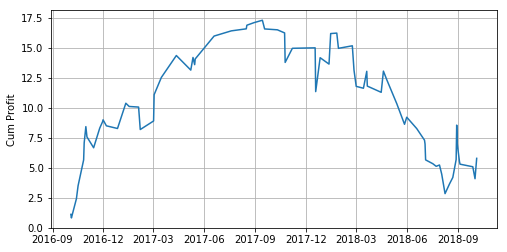

In [57]:
get_cumsum(buys['Pnl'])

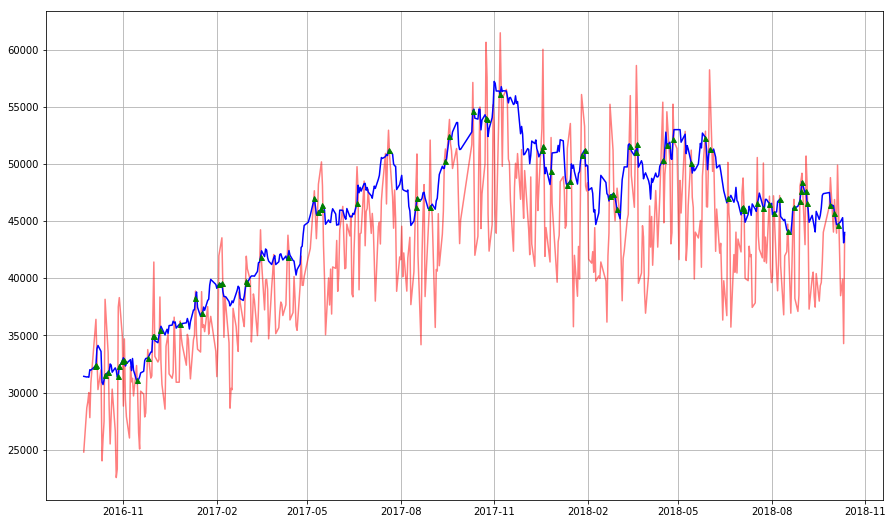

In [58]:
# 주가차트에서 매수포인트 확인
#HY_temp = HY.ix['2016-09-23':]

fig= plt.figure(figsize=(15,9))
ax1= fig.add_subplot(1,1,1)
#ax1.plot(HY_temp.index, HY_temp['Close'], color='r')
ax1.plot(tf2.index, tf2['Predicted Next Close'], color='r', alpha=0.5)
ax1.plot(tf2.index, tf2['Current Day Close'], color='b')
ax1.plot(buys.index, buys['Current Day Close'], '^', markersize=5, color='g')
ax1.grid()
plt.show()


In [ ]:
#매수 시그널 추가
hy_buy_signal= list(range(pstep+5))

for i in range(pstep+5):
    if tf['Prediction'][i] > tf['HY_t0'][i]:
        hy_buy_signal[i]= 1
    elif tf['Prediction'][i] <= tf['HY_t0'][i]:
        hy_buy_signal[i]= 0

hy_buy_signal_index= tf['Prediction'].index
buysignal= dict((key, value) for (key, value) in zip(hy_buy_signal_index, hy_buy_signal))
tf['HY_buy_signal']= pd.Series(buysignal)

#매수시점+5일후 수익률 추가
def get_ret(r):
    if r['HY_buy_signal']==1:
        return ((r['T+5 Close'] - r['HY_t0'])/r['HY_t0'])*100 - 0.5 #(거래수수료 및 세금 0.6%)
        #return ((r['T+5 Close'] - r['HY_t0']- (r['T+5 Close']*0.006))/r['HY_t0']) #(거래수수료 및 세금 0.6%)
    else:
        return 0

tf= tf.assign(Pnl = tf.apply(get_ret, axis=1))

In [61]:
# 동적시간워핑 모델링

from scipy.spatial.distance import euclidean
from fastdtw import fastdtw

# 2개의 시리즈간의 거리를 반환하는 함수
def dtw_dist(x,y):
    distance, path = fastdtw(x , y, dist=euclidean)
    return distance

#시계열데이터를 5일단위로 분할한다. 하나의 추가포인트로 기간들을 연결, x,y데이터 생성
tseries=[]
tlen=5
for i in range(tlen, len(HY), tlen):
    pctc= HY['Close'].iloc[i-tlen:i].pct_change()[1:].values*100
    res= HY['Close'].iloc[i-tlen:i+1].pct_change()[-1]*100
    tseries.append((pctc,res))     
    

In [66]:
tseries[0:2]

[(array([ 1.60692213,  2.31143552, -3.3293698 ,  0.98400984]),
  -2.923264311814855),
 (array([ 1.50564617, -1.48331273,  3.76411543,  1.81378476]),
  0.11876484560569)]

In [68]:
# 각 시리즈와 다른 시리즈간의 거리를 구한다.
dist_pairs=[]
for i in range(len(tseries)):
    for j in range(len(tseries)):
        dist= dtw_dist(tseries[i][0], tseries[j][0])
        dist_pairs.append((i,j,dist, tseries[i][1], tseries[j][1]))       


In [126]:
# 해당 데이터를 데이터 프레임 객체에 할당한다.
# 같은 시리즈를 나타내는 즉, 거리가0인 시리즈는 제외한다. 
# 시리즈를 시간으로 정렬하고 첫번째 시리즈가 시간순으로 두번째 시리즈보다 앞에 있는것만 추출한다.
dist_frame= pd.DataFrame(dist_pairs, columns=['A','B','Dist','A Ret','B Ret'])
sf= dist_frame[dist_frame['Dist'] > 0].sort_values(['A','B']).reset_index(drop=1)
sfe=sf[sf['A'] < sf['B']]

# 거리가 1보다 작고 첫번째 시리즈가 수익을 낸 것으로만 제한한다.
#winf= sfe[(sfe['Dist'] <= 1) & (sfe['A Ret'] > 0)]
winf= sfe[(sfe['Dist'] <= 1) & (sfe['A Ret'] > 0)]

In [127]:
winf

,A,B,Dist,A Ret,B Ret
3923,9,45,0.725856,4.313725,4.756098
4303,9,425,0.987245,4.313725,-0.566893
4466,10,157,0.693616,1.236094,0.645161
4579,10,270,0.685001,1.236094,3.122560
4797,11,57,0.548965,0.491400,0.544662
6399,14,366,0.829050,2.898551,-0.044743
6439,14,406,0.941022,2.898551,0.367047
7556,17,230,0.822004,3.041825,0.654664
9387,21,337,0.967271,1.254705,1.548947
12664,29,166,0.830708,0.124844,1.814516


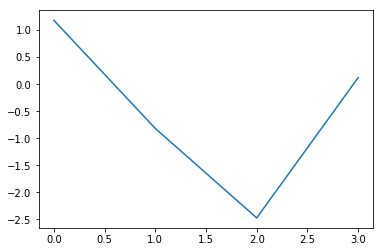

In [118]:
#수익난 패턴 그래프 그려보기
plt.plot(np.arange(4), tseries[14][0])

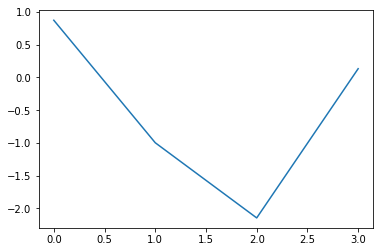

In [119]:
plt.plot(np.arange(4), tseries[366][0])

In [128]:
print('수익률합:', winf['B Ret'].sum())
get_stats(winf['B Ret'])

수익률합: 17.08834473364749
Trade: 30 
Wins: 17 
Lossed: 12 
Breakeven: 1 
Win/Loss Ratio: 1.417 
Mean Win: 1.589 
Mean Loss: -0.828 
Profit/Loss Ratio: 1.919 
Mean 0.57 
Std Dev: 1.551 
Max Loss: -3.198 
Max Win: 4.756 
Sharpe Ratio: 5.8296


In [129]:
excluded={}
return_list=[]

# 수익을 얻은 커브와 비슷한 커브는 매수한다.
# 하지만 유사커브 2번째 매수시 손실이 났을경우 해당 커브유형은 제외시킨다. 
def get_returns(r):
    if excluded.get(r['A']) is None:
        return_list.append(r['B Ret'])
        if r['B Ret']<0:
            excluded.update({r['A']:1})

winf.apply(get_returns, axis=1)

return_list

[4.756097560975614,
 -0.5668934240362855,
 0.6451612903225712,
 3.1225604996096834,
 0.5446623093681824,
 -0.04474272930649059,
 0.654664484451728,
 1.5489467162329573,
 1.814516129032251,
 0.7990165949600447,
 0.23219814241486336,
 2.19780219780219,
 -1.03719599427754,
 -0.36730945821854544,
 -0.41876046901172526,
 -0.36231884057971175,
 -1.2561060711793415,
 1.8050541516245522,
 2.3038605230386144,
 2.0618556701030855,
 -0.4524886877828038,
 2.19780219780219,
 -0.07874015748031704,
 0.7953340402969244,
 -0.29006526468455807,
 -1.8580276322058165,
 0.0]

In [131]:
print('수익률합:', pd.Series(return_list).sum())
get_stats(pd.Series(return_list))

수익률합: 18.746883779272316
Trade: 27 
Wins: 15 
Lossed: 11 
Breakeven: 1 
Win/Loss Ratio: 1.364 
Mean Win: 1.699 
Mean Loss: -0.612 
Profit/Loss Ratio: 2.776 
Mean 0.694 
Std Dev: 1.455 
Max Loss: -1.858 
Max Win: 4.756 
Sharpe Ratio: 7.5756
